In [48]:
import numpy as np
import json
import time
import os

from pymongo import MongoClient
import pygad

import matplotlib.pyplot as plt



In [52]:
def get_pokemon_individually():
    
    client = MongoClient()
    db = client['genetic_algo'] 

    # Individual pokemon's collection
    collec_indiv_pokemon = db['pokemons']
    pokemons = list(collec_indiv_pokemon.find())
    
    return pokemons

def get_pokemon_teams():
    
    client = MongoClient()
    db = client['genetic_algo'] 

    # pokemon's teams collection
    collec_poke_teams = db['pokemon_teams']
    collec_poke_teams = list(collec_poke_teams.find())
    
    for poke_team in collec_poke_teams:
        del poke_team['_id']    
    return collec_poke_teams

def best_against(pokeA, pokeB):
    
    best = 0
    pokemons_max_types = ['primaryType', 'secondaryType']
    
    for poke_typeA in pokemons_max_types:
        if poke_typeA in pokeA:

            for poke_typeB in pokemons_max_types:
                if poke_typeB in pokeB:
                    typeA_against_typeB = f'{poke_typeA}_against_{pokeB[poke_typeB]}'
                    if typeA_against_typeB in pokeA and pokeA[typeA_against_typeB] > best:

                        best = pokeA[typeA_against_typeB]
    return best



def battle(poke1, poke2):

    against1 = best_against(poke1, poke2)
    against2 = best_against(poke2, poke1)
    
    return poke1['CP'] * against1 - poke2['CP'] * against2

# Get all pokemons in a list
pokemons = get_pokemon_individually()


import matplotlib.pyplot as plt

def create_log_dirs(team_idx, ga_instance_run):

    # Diretório principal de resultados
    target_dir = os.path.join(os.getcwd(), 'Resultados')

    # Garantir que o diretório "Resultados" exista
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Diretório específico do time
    folder_name = os.path.join(target_dir, f'RivalTeam_{team_idx}')
    
    # Garantir que o diretório do time exista
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

    # Caminho onde o resultado da execução será salvo
    folder_target_ga_instance = os.path.join(folder_name, 'execution 1')

    # Salvando a instância do GA no diretório
    ga_instance_run.save(folder_target_ga_instance)

    # Plotando e salvando o gráfico de fitness
    ga_instance_run.plot_fitness(label=['Obj 1', 'Obj 2'])

    # Caminho para salvar o gráfico
    folder_target_fitness_plot = os.path.join(folder_name, 'fitness_plot.png')

    # Salvando o gráfico no diretório correto
    plt.savefig(folder_target_fitness_plot, dpi=400)

    # Fechar a figura para evitar problemas com novos plots
    plt.close()



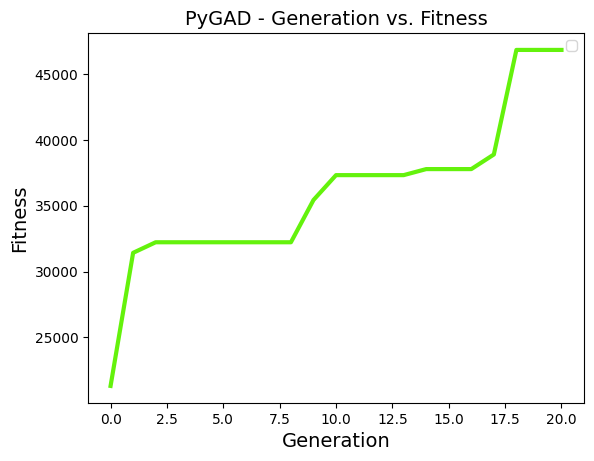

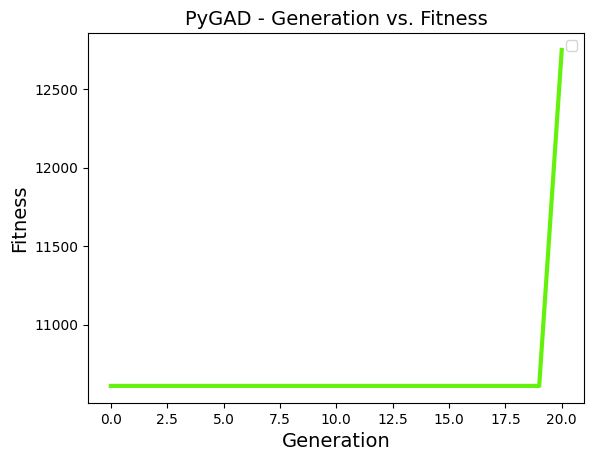

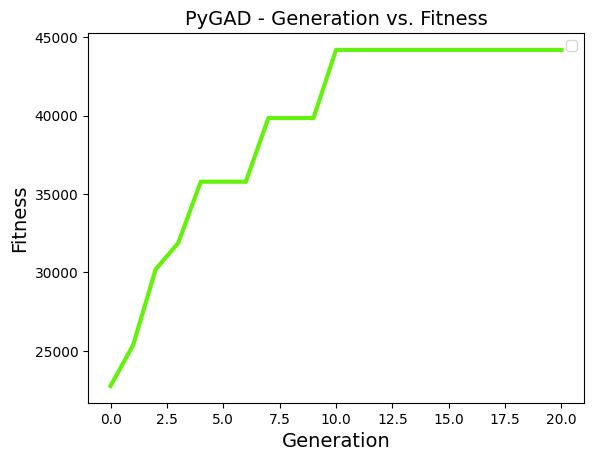

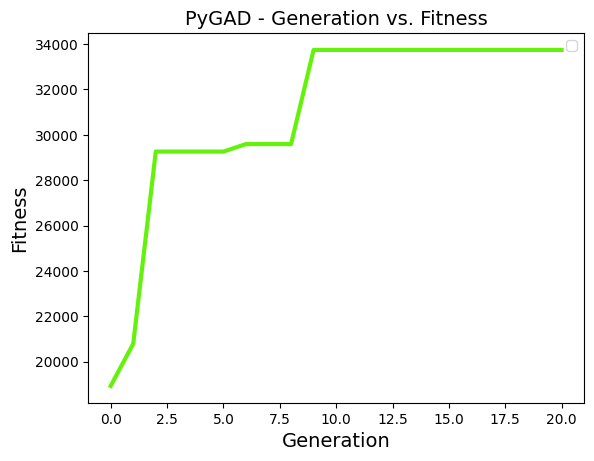

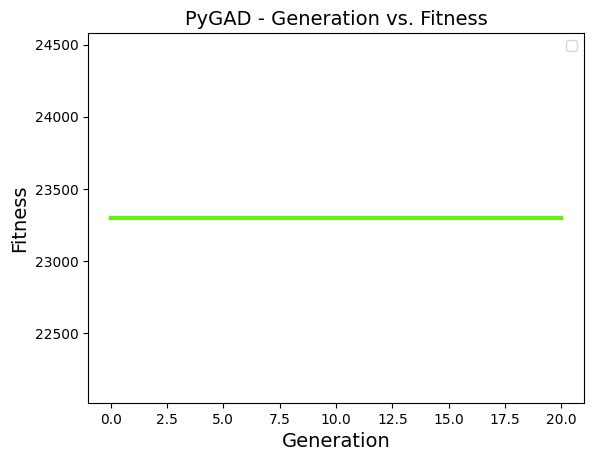

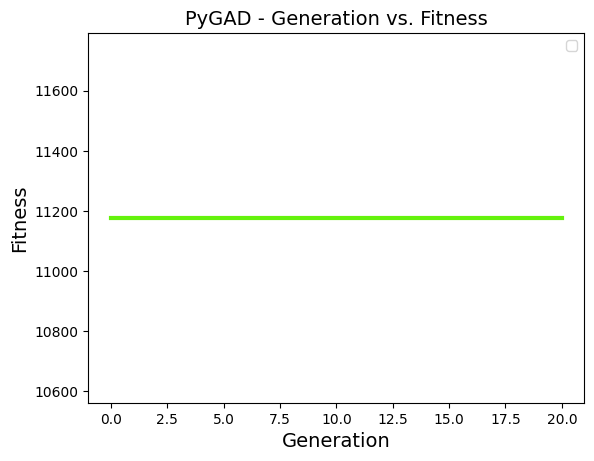

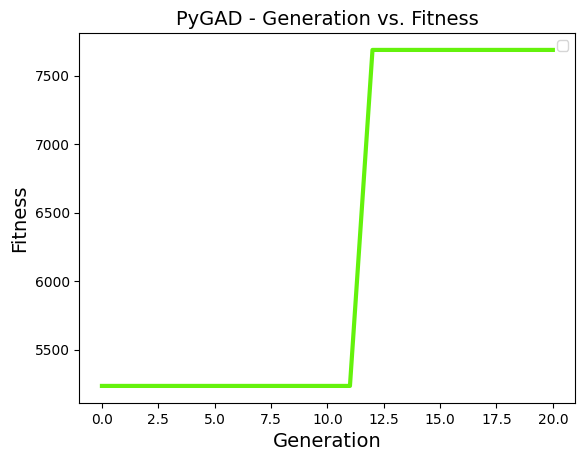

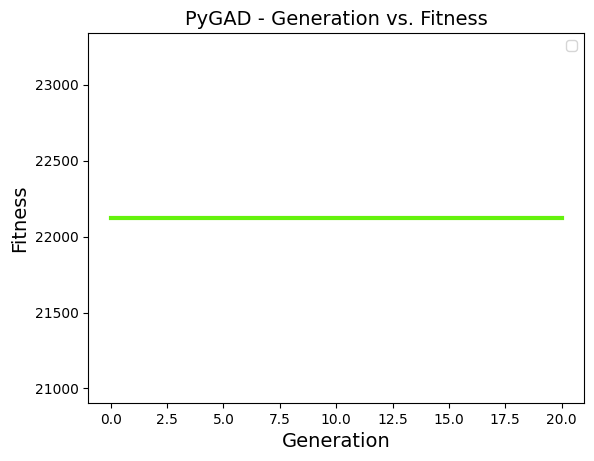

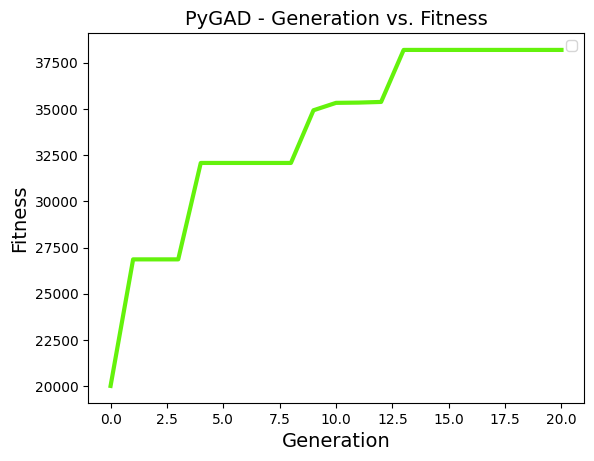

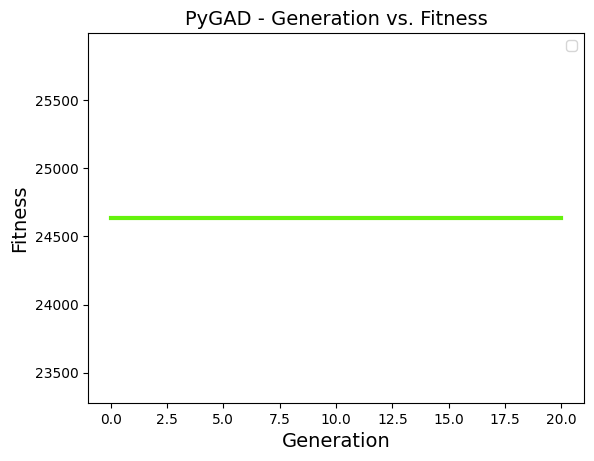

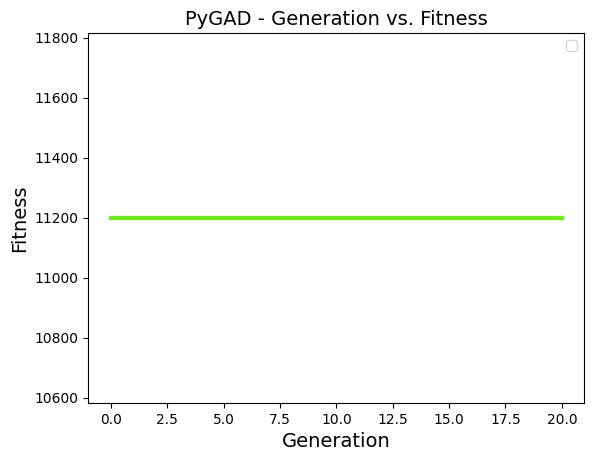

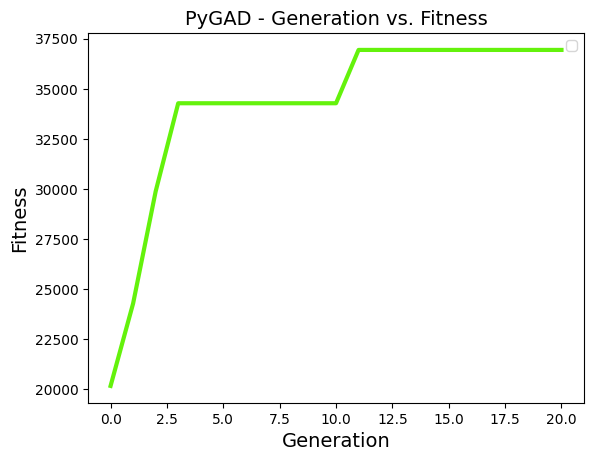

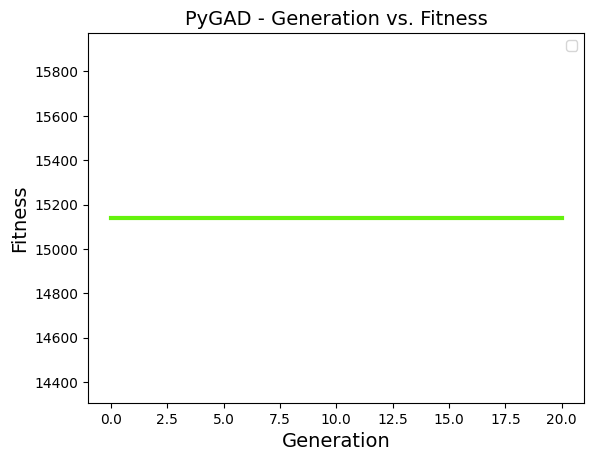

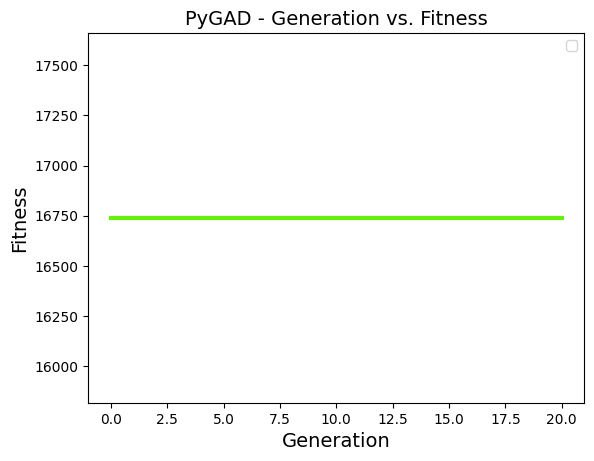

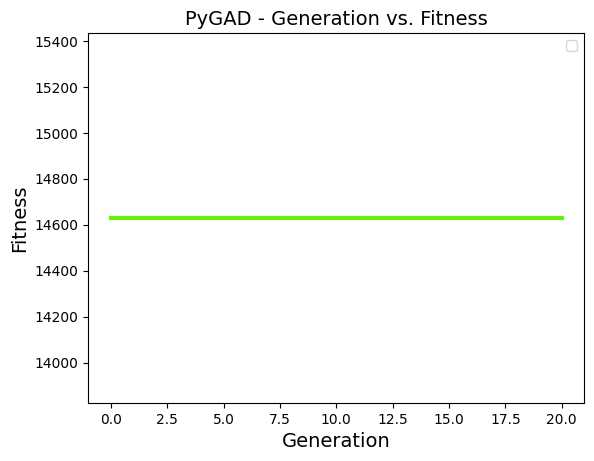

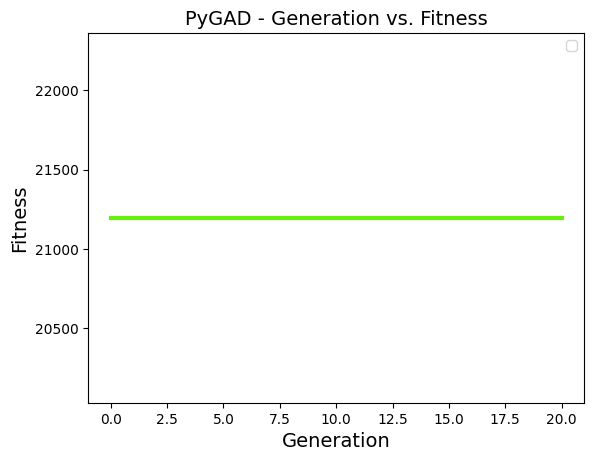

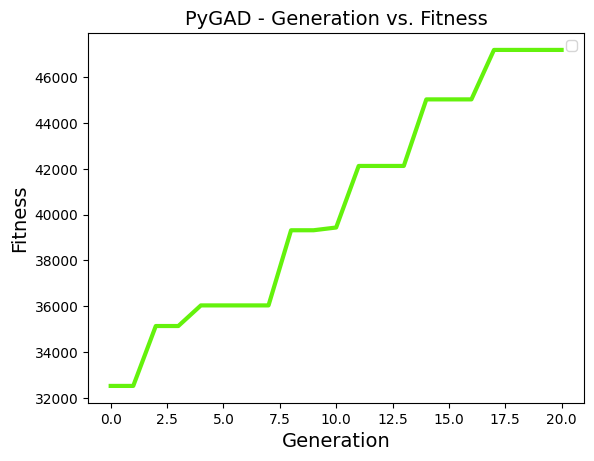

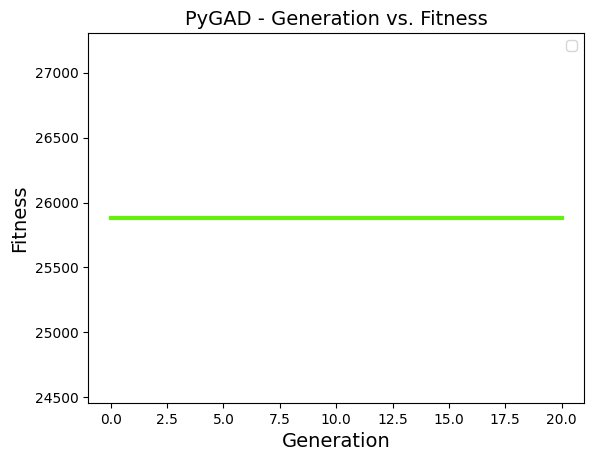

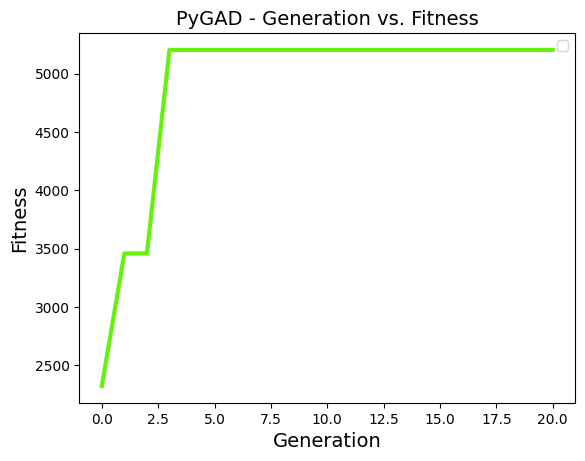

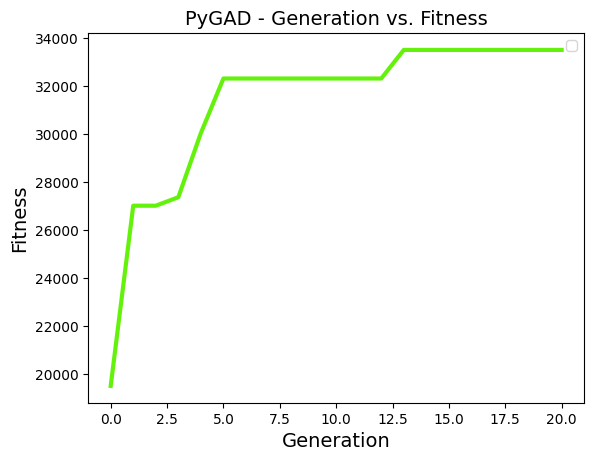

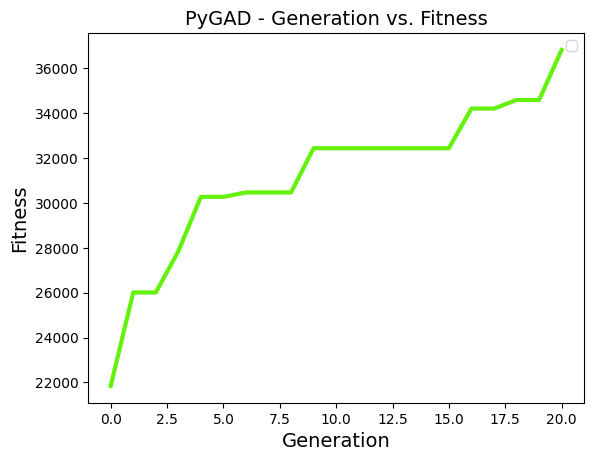

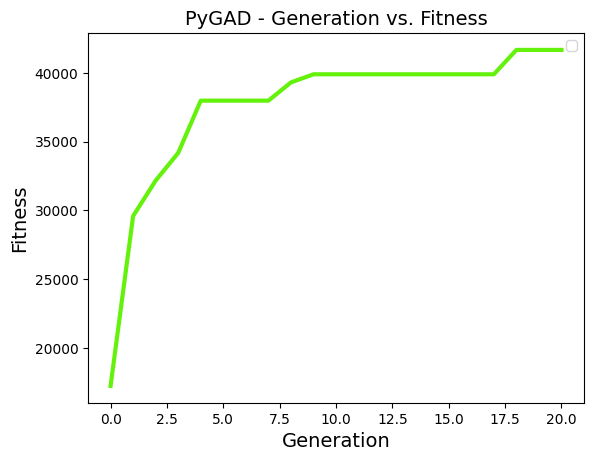

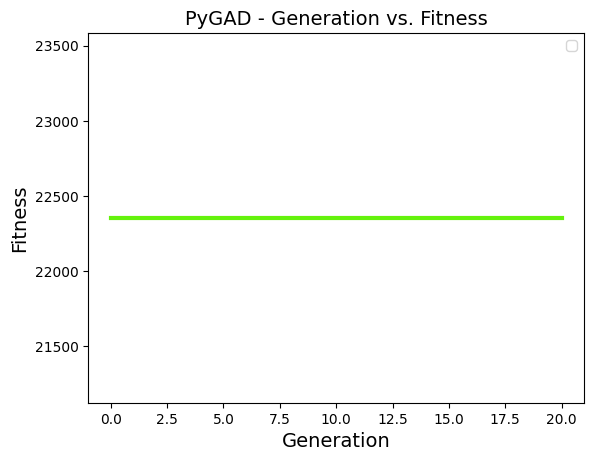

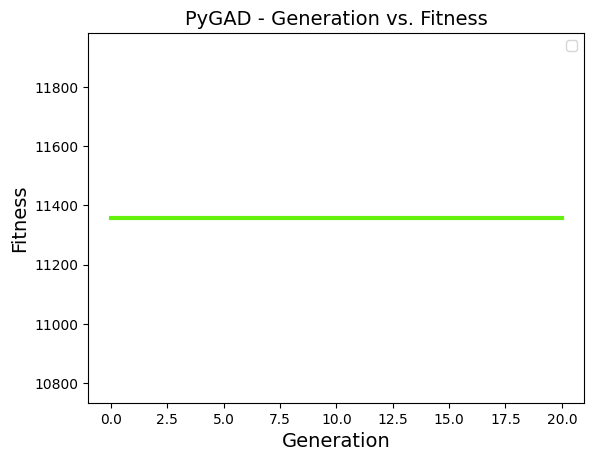

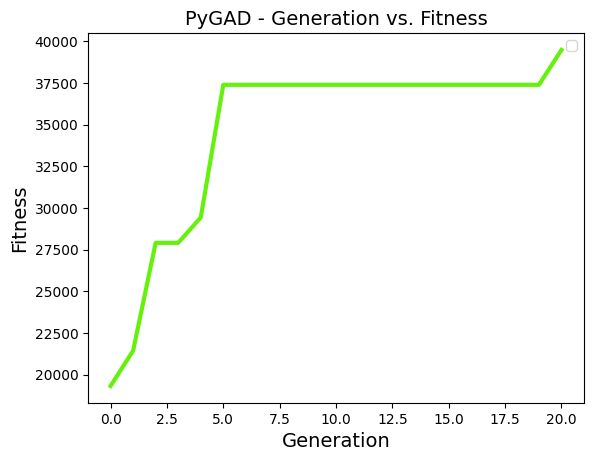

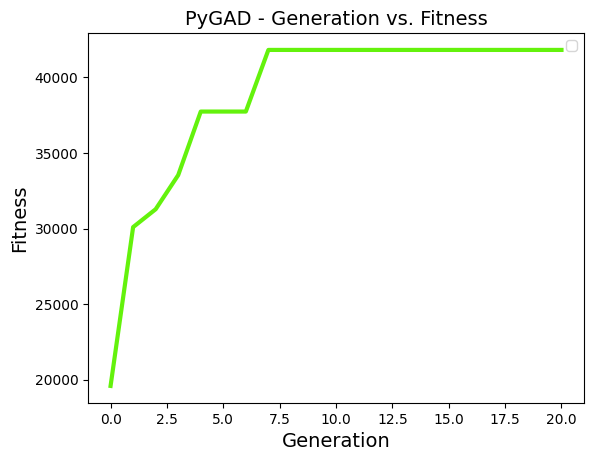

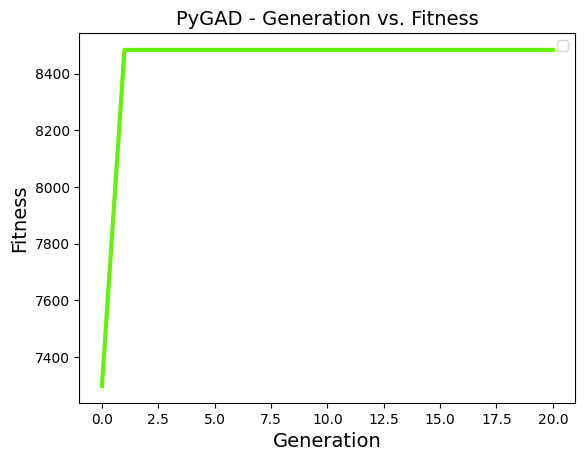

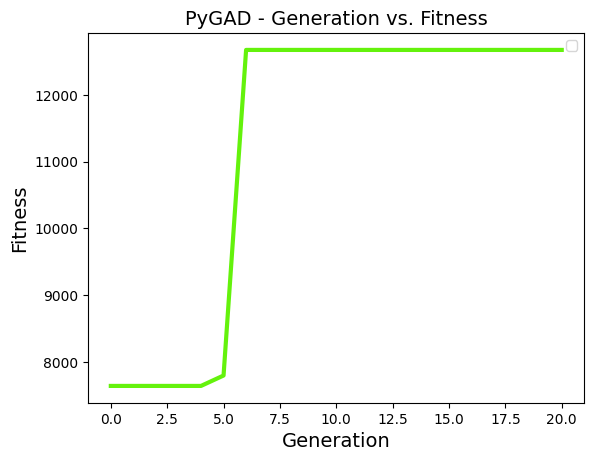

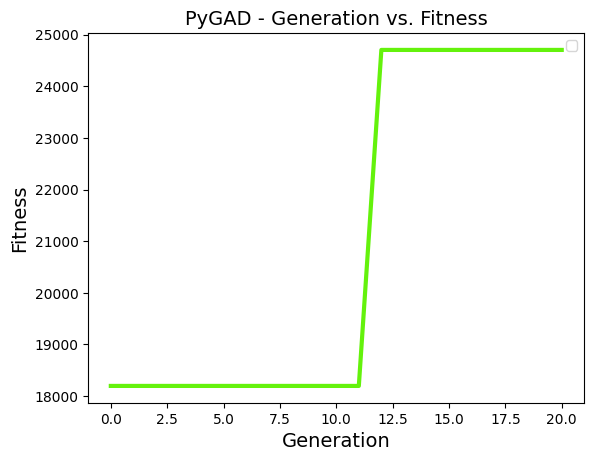

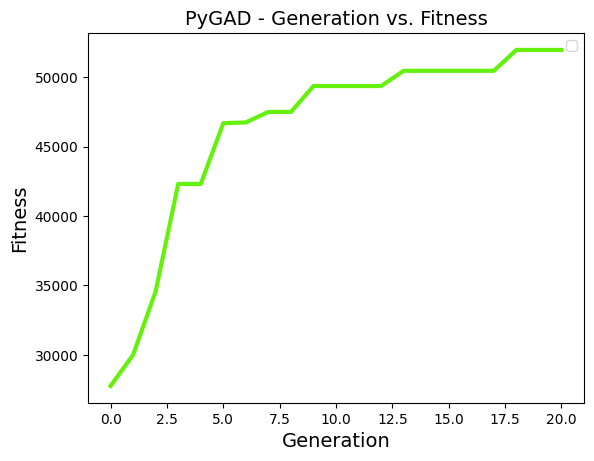

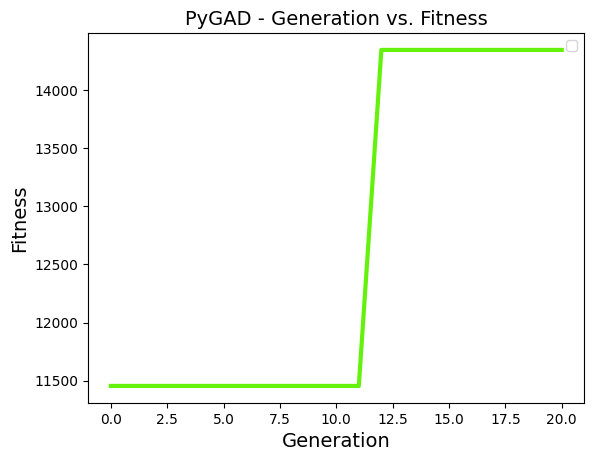

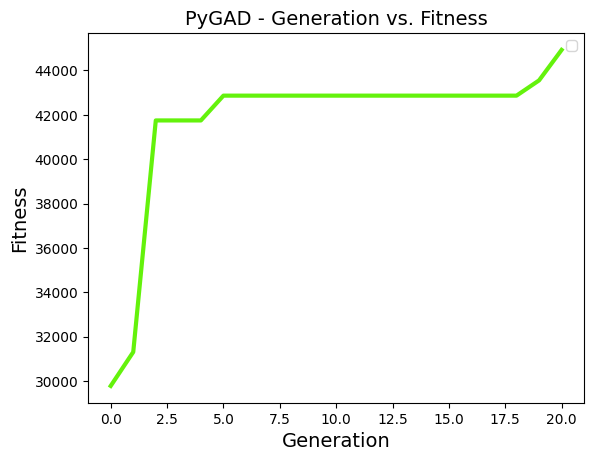

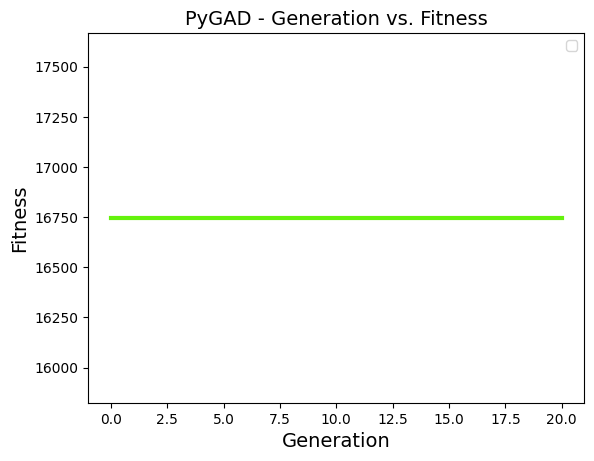

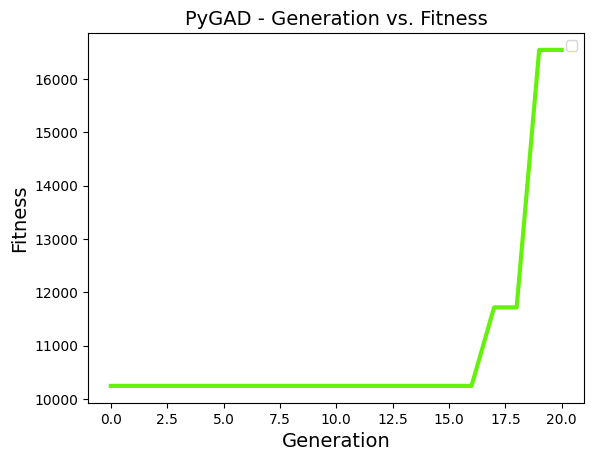

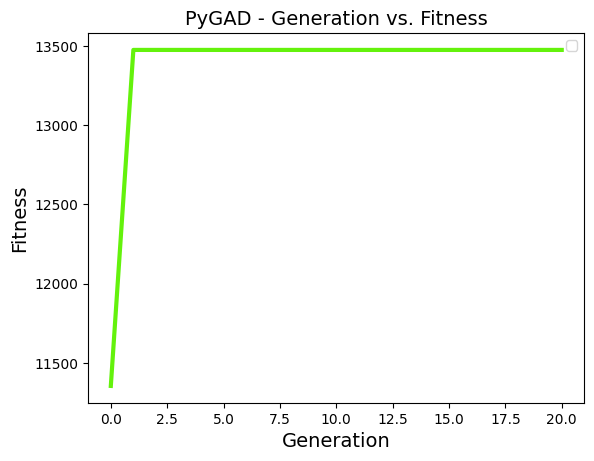

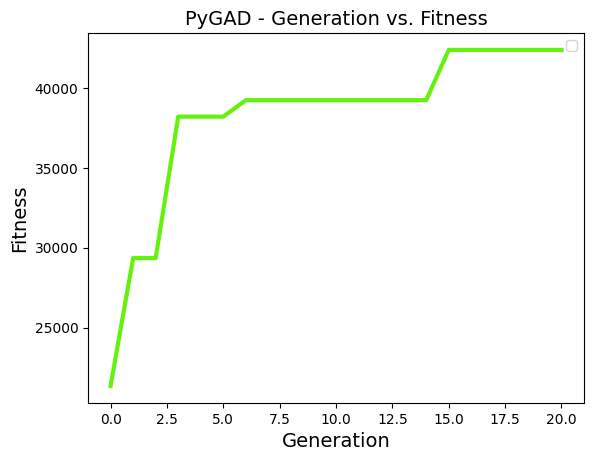

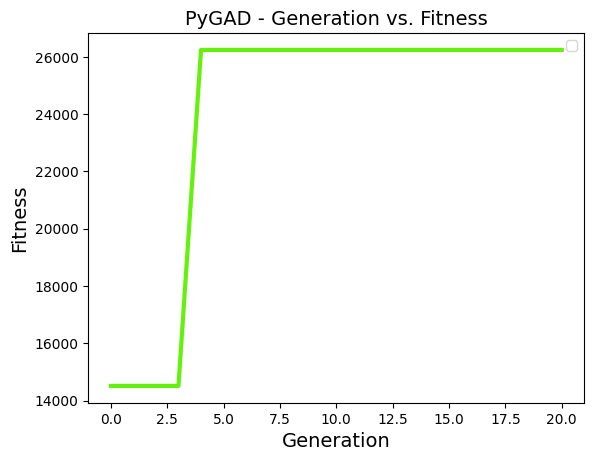

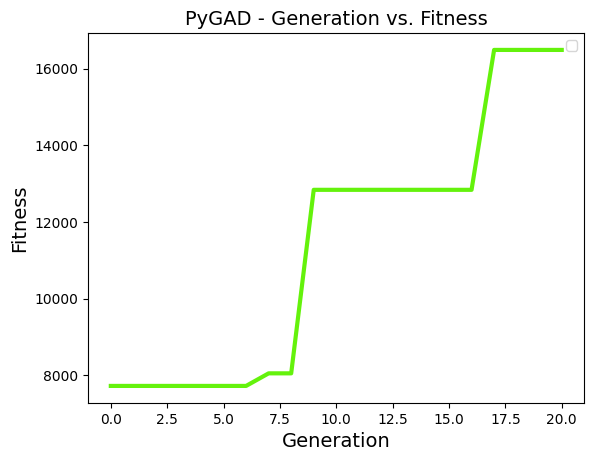

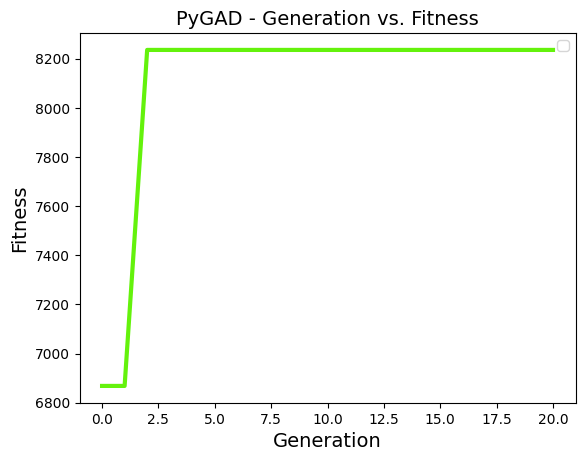

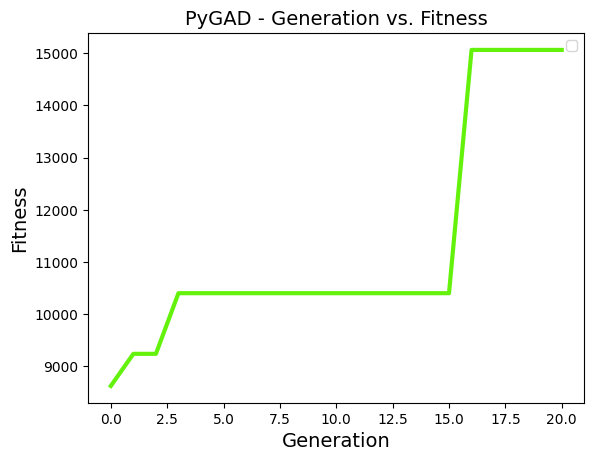

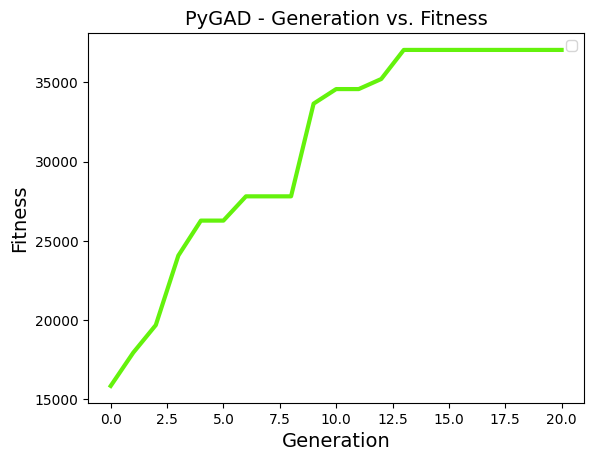

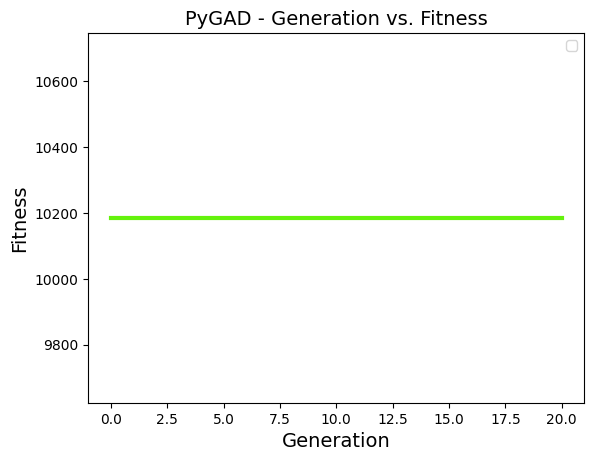

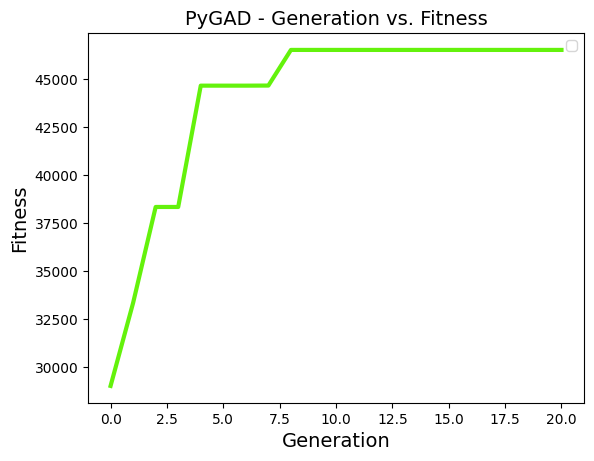

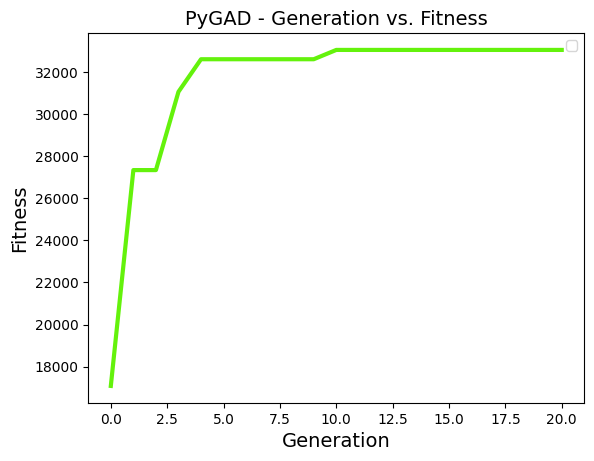

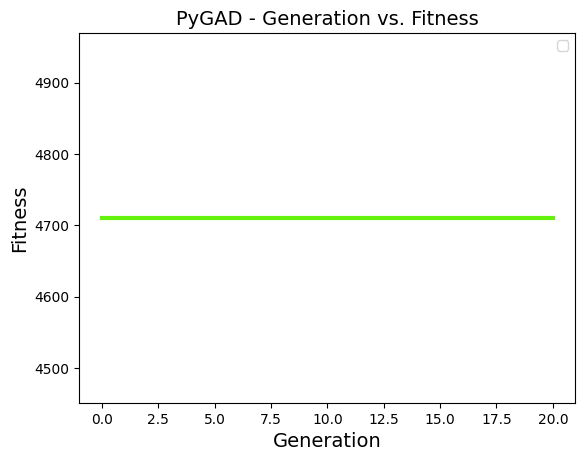

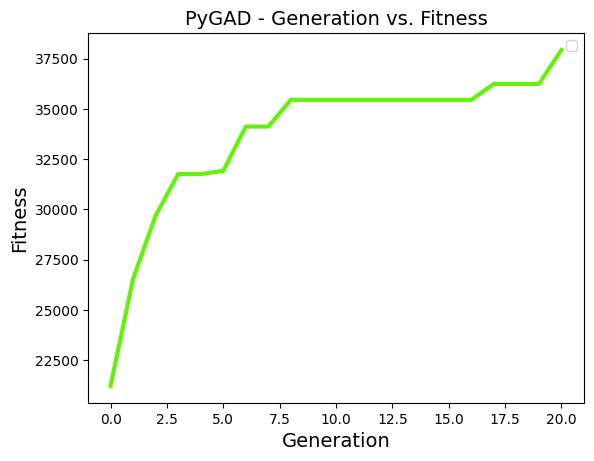

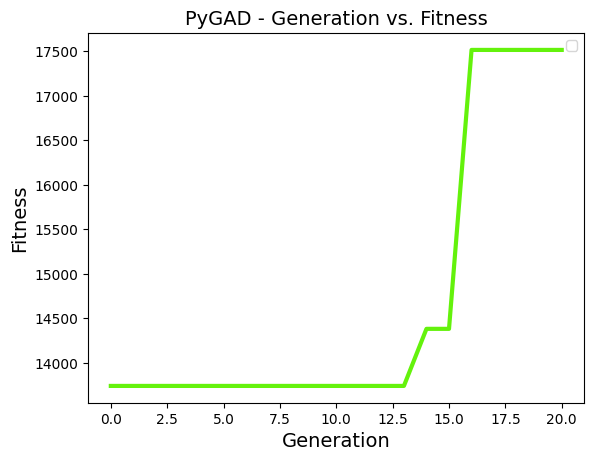

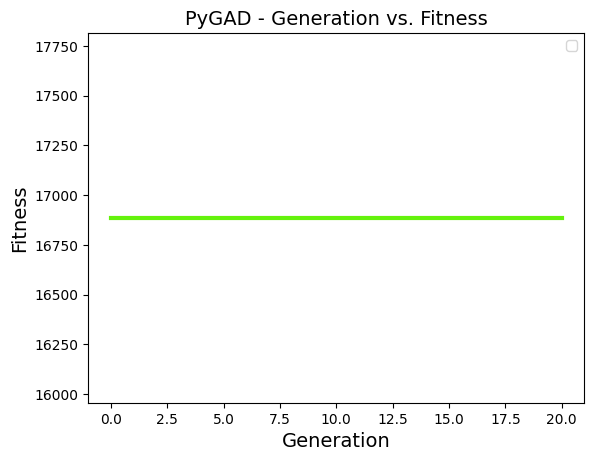

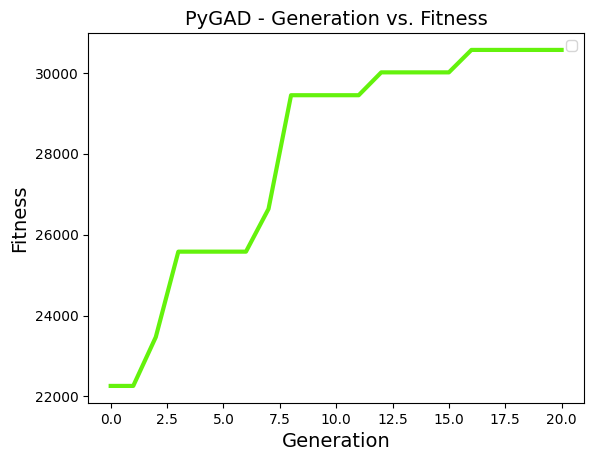

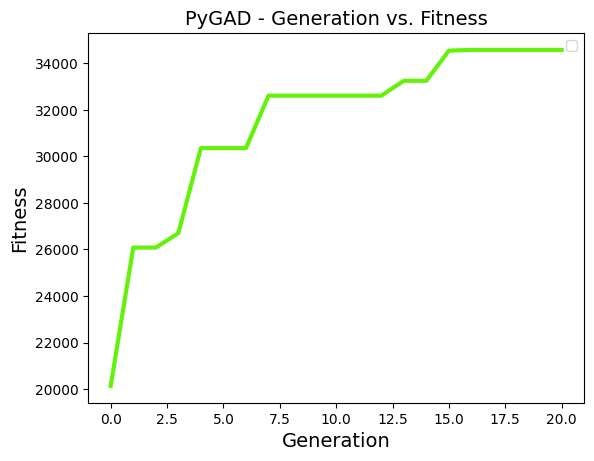

In [53]:
def fitness_func(ga_instance, solution, solution_idx):
    # Starts the fit value with 0
    fit = 0

    # Getting the rival team from the global variable
    global rival_team

    solution_team = [pokemons[solution_pokemon] for solution_pokemon in solution]
    for home_pokemon in solution_team:
        for rival_pokemon in rival_team:
            fit += battle(home_pokemon, rival_pokemon)

    return fit

fitness_function = fitness_func
parent_selection_type = 'rws'
crossover_type = "single_point"
mutation_type="random"

def run_genetic_algorithm():
    poke_rival_teams = get_pokemon_teams()[:50]
    results = dict()

    for rival_team_idx, rv_team_db in enumerate(poke_rival_teams):

        # Creating the global rival_team variable
        globals()['rival_team'] = rv_team_db[f'Team {rival_team_idx}'] 

        # Defining the fitnesse function
        fitness_function = fitness_func

        
        ga_instance = pygad.GA(num_generations = 20,
                               num_parents_mating = 50 ,
                               fitness_func = fitness_function,
                               gene_type = int,
                               init_range_low = 0,
                               init_range_high = len(pokemons),
                               gene_space = np.arange(len(pokemons)),
                               sol_per_pop = 50,
                               num_genes = 3,
                               parent_selection_type = parent_selection_type,
                               crossover_type=crossover_type,
                               crossover_probability = 0.8,
                               mutation_probability = 0.2,
                               mutation_by_replacement = True,
                               allow_duplicate_genes = False,
                               mutation_type = mutation_type,
                               random_mutation_min_val = 0,
                               random_mutation_max_val = len(pokemons),
                               save_solutions = True,
                               keep_parents = 1)

        ga_instance.run()

        create_log_dirs(rival_team_idx, ga_instance)

        #results[rival_team_idx] = dict(
                                       #best_solutions= ga_instance.best_solutions.tolist(),
                                       #best_solutions_fitness = ga_instance.best_solutions_fitness)
    
    return results

# Rodar o algoritmo
results = run_genetic_algorithm()





In [23]:
function_inputs = [4,-2,3.5,5,-11,-4.7]
desired_output = 44

def fitness_func(ga_instance, solution, solution_idx):
    output = np.sum(solution*function_inputs)
    fitness = 1.0 / np.abs(output - desired_output)
    return fitness

fitness_function = fitness_func

num_generations = 50
num_parents_mating = 4

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10




ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

prediction = np.sum(np.array(function_inputs)*solution)
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

Parameters of the best solution : [ 2.93693861e+00  2.48342512e+00  4.13294127e+00 -2.46607706e-03
 -2.41060147e+00  7.95315519e-01]
Fitness value of the best solution = 79.99023377647129
Predicted output based on the best solution : 44.01250152615874
